# Table of Contents
1. [Define Model](#Define-Model)
2. [Optimize Model](#Optimize-Model)
3. [Interval Arithmetic](#Interval-Arithmetic)
4. [Algorithmic Differentiation](#Algorithmic-Differentiation)
5. [Model Transformations](#Model-Transformations)
6. [Interval-Primal and Interval-Adjoint](#Interval-Primal-and-Interval-Adjoint)
7. [Remove Neurons One-at-a-time](#Remove-Neurons-One-at-a-time)
8. [Neurons Significance](#Neurons-Significance)
9. [Analyze Neuron Significance with Loss](#Analyze-Neuron-Significance-with-Loss) 

In [1]:
import torch
import functools
import torch.nn as nn
import numpy as np
import copy
import matplotlib.pyplot as plt
import torch.optim as optim
from abc import abstractmethod
from typing import Union, TypeAlias, Iterable
import torch.nn.modules.activation as activation
from typing_extensions import Protocol, runtime_checkable

### Define Model

In [2]:
def f(x):
    return x[:, 0] * x[:, 1] + x[:, 0] ** 2

In [3]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 3)
        self.fc2 = nn.Linear(3, 2)
        self.fc3 = nn.Linear(2, 1)
        self.activation = nn.Sigmoid()  # Using Sigmoid activation function

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [4]:
model = Net()

In [5]:
def plot_function(func, x_range=(-1, 1), y_range=(-1, 1), num_points=100):
    x = torch.linspace(x_range[0], x_range[1], num_points)
    y = torch.linspace(y_range[0], y_range[1], num_points)
    X, Y = torch.meshgrid(x, y)
    Z = func(torch.stack([X.flatten(), Y.flatten()], dim=1)).reshape(X.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(X.numpy(), Y.numpy(), Z.detach().numpy(), levels=50, cmap='viridis')
    plt.colorbar(label='Function Value')
    plt.title('Function f Plot')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.savefig('function_plot.png', dpi=300)
    plt.show()

Z:\workspace\venv\envTorch\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


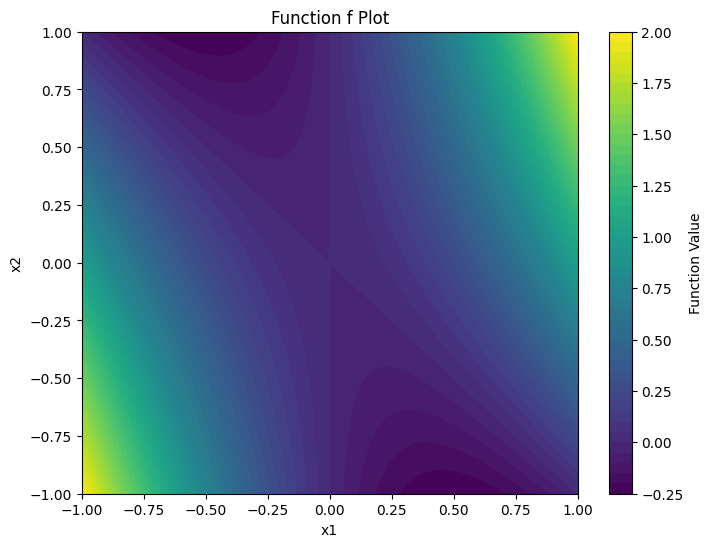

In [6]:
plot_function(f)

### Optimize Model

In [7]:
def train(model):
    
    N = 1000
    x_train = 2 * torch.rand(N, 2) - 1  # values in [-1, 1]
    y_train = f(x_train).unsqueeze(1)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 2000
    train_losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")
    return train_losses, model

In [8]:
train_losses, model = train(model)

Epoch 500, Loss: 0.191578
Epoch 1000, Loss: 0.155270
Epoch 1500, Loss: 0.028821
Epoch 2000, Loss: 0.006471


In [9]:
def plot_loss():
    plt.plot(train_losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.savefig('train_loss.png', dpi=300)
    plt.show()

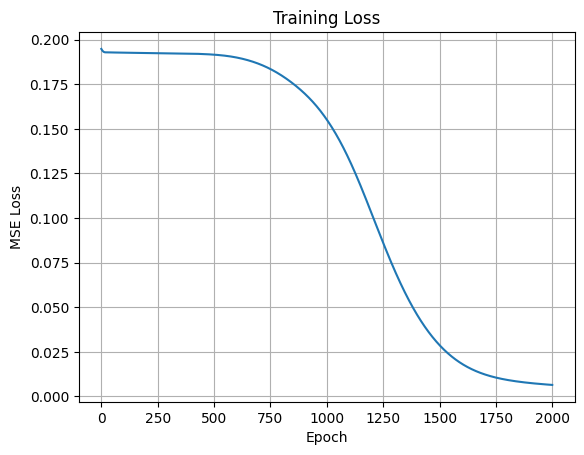

In [10]:
plot_loss()

In [185]:
use_thesis_weights = True
if use_thesis_weights:
    model.fc1.weight = torch.nn.Parameter(torch.Tensor([[-3.0554, -1.8597],
                                                         [-1.1743,  2.5568],
                                                         [-2.2772, -0.5027]]))
    model.fc1.bias = torch.nn.Parameter(torch.Tensor([ 2.6050, -2.0148, -1.5579]))
    model.fc2.weight = torch.nn.Parameter(torch.Tensor([[-1.9755, -0.9540, 2.5965],
                                                        [2.5450,  0.7510, -2.0245]]))
    model.fc2.bias = torch.nn.Parameter(torch.Tensor([0.6572, -1.4918]))
    model.fc3.weight = torch.nn.Parameter(torch.Tensor([[ 2.1636, -2.4127]]))
    model.fc3.bias = torch.nn.Parameter(torch.Tensor([0.8917]))

In [186]:
model.fc1.weight.shape, model.fc1.bias.shape, model.fc2.weight.shape, model.fc2.bias.shape, model.fc3.weight.shape, model.fc3.bias.shape

(torch.Size([3, 2]),
 torch.Size([3]),
 torch.Size([2, 3]),
 torch.Size([2]),
 torch.Size([1, 2]),
 torch.Size([1]))

### Interval Arithmetic

In [190]:

class Interval:

    def __init__(self, lower: Union[torch.Tensor, int, float], upper: Union[torch.Tensor, int, float]):
        self.lower = lower if isinstance(lower, torch.Tensor) else torch.as_tensor(lower)
        self.upper = upper if isinstance(upper, torch.Tensor) else torch.as_tensor(upper)

        if (self.lower > self.upper).any():
            raise Exception("Invalid Interval!")

    def __repr__(self):
        return f"({self.lower}, {self.upper})"
    
    def __eq__(self, right_operand: 'Interval'):
        if isinstance(right_operand.lower, int | float):
            if self.lower == right_operand.lower and self.upper == right_operand.upper:
                return True
            return False
        if (self.lower == right_operand.lower).all() and (self.upper == right_operand.upper).all():
                return True
        return False
        
    def __add__(self, right_operand: Union[torch.Tensor, 'Interval']):
        if right_operand.__class__ != Interval:
            lb = self.lower + right_operand
            ub = self.upper + right_operand
            return Interval(lb, ub)
        lb = self.lower + right_operand.lower
        ub = self.upper + right_operand.upper
        return Interval(lb, ub)

    def __radd__(self, left_operand: Union[torch.Tensor, int, float]):
        lb = left_operand + self.lower
        ub = left_operand + self.upper
        return Interval(lb, ub)

    def __sub__(self, right_operand: Union[torch.Tensor, 'Interval']):
        if right_operand.__class__ != Interval:
            lb = self.lower - right_operand
            ub = self.upper - right_operand
            return Interval(lb, ub)
        lb = self.lower - right_operand.upper
        ub = self.upper - right_operand.lower
        return Interval(lb, ub)

    def __rsub__(self, left_operand: Union[torch.Tensor, int, float]):
        return Interval(left_operand, left_operand) - self
        
    def __mul__(self, right_operand: Union['Interval', torch.Tensor, int, float]):
        if right_operand.__class__ != Interval:
            p1 = self.lower * right_operand
            p2 = self.upper * right_operand
            lb = functools.reduce(torch.min, [p1, p2])
            ub = functools.reduce(torch.max, [p1, p2])
            return Interval(lb, ub)
    
        p1 = self.lower * right_operand.lower 
        p2 = self.lower * right_operand.upper 
        p3 = self.upper * right_operand.lower 
        p4 = self.upper * right_operand.upper
        lb = functools.reduce(torch.min, [p1, p2, p3, p4])
        ub = functools.reduce(torch.max, [p1, p2, p3, p4])
        return Interval(lb, ub)
 
    def __rmul__(self, left_operand: Union[torch.Tensor, int, float]):
        p1 = left_operand * self.lower
        p2 = left_operand * self.upper 
        lb = functools.reduce(torch.min, [p1, p2])
        ub = functools.reduce(torch.max, [p1, p2])
        return Interval(lb, ub)

    def __matmul__(self, right_operand: Union['Interval', torch.Tensor, int, float]):
        
        if right_operand.__class__ != Interval:
            b_pos, b_neg = self.positive_and_negative_parts(right_operand)
            lb = (self.lower @ b_pos) + (self.upper @ b_neg)
            ub = (self.upper @ b_pos) + (self.lower @ b_neg)
            return Interval(lb, ub)

        u, v = self.lower, self.upper
        w, x = right_operand.lower, right_operand.upper
        u_pos, u_neg = self.positive_and_negative_parts(u)
        v_pos, v_neg = self.positive_and_negative_parts(v)
        w_pos, w_neg = self.positive_and_negative_parts(w)
        x_pos, x_neg = self.positive_and_negative_parts(x)
    
        min_pairs = [(u_pos, w_pos), (v_pos, w_neg),
                    (u_neg, x_pos), (v_neg, x_neg)]
        min_vals = functools.reduce( torch.add, [x @ y for x, y in min_pairs])
        max_pairs = [(v_pos, x_pos), (v_neg, w_pos),
                    (u_pos, x_neg), (u_neg, w_neg)]
        max_vals = functools.reduce( torch.add, [x @ y for x, y in max_pairs])
        return Interval(min_vals, max_vals)
    
    def __rmatmul__(self, left_operand: Union[torch.Tensor, int, float] ):
        a_pos, a_neg = self.positive_and_negative_parts(left_operand)
        lb = a_pos @ self.lower + a_neg @ self.upper
        ub = a_pos @ self.upper + a_neg @ self.lower
        return Interval(lb, ub)
    
    def __gt__(self, right_operand: Union['Interval', torch.Tensor, int, float]):
        if right_operand.__class__ != Interval:
            lb = (self.lower > right_operand).float()
            ub = (self.upper > right_operand).float()
            return Interval(lb, ub)
        lb = (self.lower > right_operand.lower).float()
        ub = (self.upper > right_operand.upper).float()
        return Interval(lb, ub)

    def __lt__(self, right_operand: Union['Interval', torch.Tensor, int, float]):
        if right_operand.__class__ != Interval:
            lb = (self.lower < right_operand).float()
            ub = (self.upper < right_operand).float()
            return Interval(lb, ub)
        lb = (self.lower < right_operand.lower).float()
        ub = (self.upper < right_operand.upper).float()
        return Interval(lb, ub)
    
    def __abs__(self):
        lb = torch.abs(self.lower)
        ub = torch.abs(self.upper)
        return Interval(torch.minimum(lb, ub), torch.maximum(lb, ub))
    
    @property
    def shape(self):
        return self.lower.shape
    
    @property
    def T(self):
        return Interval(self.lower.T, self.upper.T)
    
    @property
    def width(self):
        return abs(self.upper - self.lower)

    @staticmethod
    def positive_and_negative_parts(x):
        return torch.maximum(torch.tensor(0), x), torch.minimum(torch.tensor(0), x)
    
    @staticmethod
    def sigmoid(x):
        if x.__class__ != Interval:
            return torch.sigmoid(x)
        return Interval(torch.sigmoid(x.lower), torch.sigmoid(x.upper))
    

### Algorithmic Differentiation

In [218]:

TensorOrInterval: TypeAlias = Union[torch.Tensor, Interval]

@runtime_checkable
class NNLayerProtocol(Protocol):

    @property
    @abstractmethod
    def grad(self) -> bool: ...

    @abstractmethod
    def forward(self, x: TensorOrInterval): ...
    
    @abstractmethod
    def backward(self, input_adjoint: TensorOrInterval): ...

NNModuleLike: TypeAlias = Iterable[NNLayerProtocol]

class Sigmoid(NNLayerProtocol):
    
    @property
    def grad(self):
        return False
    
    def __init__(self, name: str = ''):
        self.primal = None
        self.name = name
    
    def forward(self, x):
        self.primal =  Interval.sigmoid(x)
        return self.primal
    
    def backward(self, input_adjoint):
        derivative = lambda x: x * (1 - x)
        if not isinstance(self.primal, Interval):
            return input_adjoint * derivative(self.primal)
        
        d_lower = derivative(self.primal.lower)
        d_upper = derivative(self.primal.upper)
        # Handle non-monotonic case (0 ∈ [lb, ub])
        # if (self.primal.lower < 0).any() and (self.primal.upper > 0).any():
        d_max = torch.tensor(0.25)  # Global max of σ'
        d_lower = torch.minimum(d_lower, d_max)
        d_upper = torch.maximum(d_upper, d_max)
        return input_adjoint * Interval(d_lower, d_upper)
    
    
class FCLayer(NNLayerProtocol):

    @property
    def grad(self):
        return True

    def __init__(self, layer: torch.nn.Linear, name: str = ''):
        ### since torch nn.Linear transpose the weights, 
        ### hence, we reverse it back to standard.
       
        self.name = name
        self.weight = layer.weight.data.T.clone() 
        self.bias = layer.bias.data.T.clone() if layer.bias is not None else None

        self.primal = None
        self.adjoint = None

        ### if pruning connections: 
        self.weight_grad =  torch.zeros_like(self.weight)
        self.bias_grad =  torch.zeros_like(self.bias) if layer.bias is not None else None

    def forward(self, x):
        self.primal = x @ self.weight
        if self.bias is not None:
            self.primal += self.bias
        return self.primal

    def backward(self, input_adjoint):
        self.adjoint = input_adjoint
        return input_adjoint @ self.weight.T

    def adjoint_wrt_weight(self, input_primal, input_adjoint):
        ### if pruning connections:
        self.weight_grad += input_primal.T @ input_adjoint
        if self.bias_grad is not None: 
            self.bias_grad += input_adjoint
        return (input_adjoint @ self.weight.T) 


class AD:

    @classmethod
    def forward_pass(cls, x: TensorOrInterval, model: NNModuleLike) -> TensorOrInterval:
        for layer in model: 
            x = layer.forward(x)
            # print(layer.name)
            # print(x)
        return x, model

    @classmethod
    def backward_pass(cls, x: TensorOrInterval, model: NNModuleLike) -> TensorOrInterval:
        input_adjoint = torch.full((model[-1].primal.shape), 1.0)
        if isinstance(x, Interval): 
            input_adjoint = Interval(input_adjoint, input_adjoint)
        print('Seed : ', input_adjoint)
        for i in reversed(range(len(model))): 
            input_adjoint = model[i].backward(input_adjoint)
            if model[i].grad:
                print(f'{model[i].name} weight: {model[i].weight.T}')
            print(f"{model[i].name} Input Adjoint : {input_adjoint}")
            print('--' * 20)
            
        return input_adjoint, model
   
    @classmethod
    def backward(cls, x: TensorOrInterval, model: NNModuleLike):
        x_primal, model = cls.forward_pass(x, model)
        x_adjoint, model = cls.backward_pass(x, model)
        return x_primal, x_adjoint, model

    

### Model Transformations

In [192]:
activation_functions = tuple(cls for cls in activation.__dict__.values() if isinstance(cls, type))

mapping = { nn.modules.linear.Linear: FCLayer, 
            # nn.modules.activation.ReLU: Relu,
            nn.modules.activation.Sigmoid: Sigmoid}
    
def nnModule_to_nnModuleLike(model: nn.Module) -> NNModuleLike:
    layers = list()
    traced = torch.fx.symbolic_trace(model)
    for layer in traced.graph.nodes:
        if layer.op == "call_module":
            t_layer = getattr(model, layer.target)
            layer_type = type(t_layer)
            mapped_layer = mapping[layer_type](layer.name) if layer_type in activation_functions else mapping[layer_type](t_layer, layer.name)
            layers.append(mapped_layer)
    return layers

def nnModuleLike_to_nnModule(layers: NNModuleLike, model: nn.Module) -> nn.Module:
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            for layer in layers:
                if layer.name == name:
                    module.out_features = layer.weight.T.shape[0]
                    module.in_features = layer.weight.T.shape[1]
                    module.weight.data = layer.weight.T.clone()
                    module.bias.data = layer.bias.T.clone()
                    break
    return model
    

### Interval-Primal and Interval-Adjoint

In [193]:
def interval_primal_adjoint(modelLike):
    lbs = torch.tensor([-1.0, -1.0])
    ubs = torch.tensor([1.0, 1.0])
    ival = Interval(lbs, ubs)
    return AD.backward(ival, modelLike)

In [219]:
modelLike = nnModule_to_nnModuleLike(model)
ival_primal, ival_adjoint, modelLike = interval_primal_adjoint(modelLike)
for layer in modelLike:
    if layer.grad:
        print('layer name: ', layer.name)
        print('weights: ', layer.weight)
        print('bias: ', layer.bias)
        print('primals: ', layer.primal)
        print('adjoints: ', layer.adjoint)
        print('-' * 20)
    else:
        print('layer name: ', layer.name)
        print('primals: ', layer.primal)
        print('-' * 20)
        

Seed :  (tensor([1.]), tensor([1.]))
fc3 weight: tensor([[ 2.1636, -2.4127]])
fc3 Input Adjoint : (tensor([ 2.1636, -2.4127]), tensor([ 2.1636, -2.4127]))
----------------------------------------
activation_1 Input Adjoint : (tensor([ 0.2115, -0.6032]), tensor([ 0.5409, -0.1277]))
----------------------------------------
fc2 weight: tensor([[-1.9755, -0.9540,  2.5965],
        [ 2.5450,  0.7510, -2.0245]])
fc2 Input Adjoint : (tensor([-2.6036, -0.9690,  0.8078]), tensor([-0.7429, -0.2977,  2.6256]))
----------------------------------------
activation Input Adjoint : (tensor([-0.6509, -0.2423,  0.0103]), tensor([-0.0610, -0.0009,  0.6564]))
----------------------------------------
fc1 weight: tensor([[-3.0554, -1.8597],
        [-1.1743,  2.5568],
        [-2.2772, -0.5027]])
fc1 Input Adjoint : (tensor([-1.3072, -0.8359]), tensor([2.2498, 1.2029]))
----------------------------------------
layer name:  fc1
weights:  tensor([[-3.0554, -1.1743, -2.2772],
        [-1.8597,  2.5568, -0.5027

In [195]:
neuron_labels = [r'$n_{1,1}$', r'$n_{1,2}$', r'$n_{1,3}$', r'$n_{2,1}$', r'$n_{2,2}$', r'$n_{3,1}$']

In [196]:
def plot_primals():

    primals = []
    for layer in modelLike:
        if layer.grad:
            for i in range(len(layer.primal.lower)):
                primals.append([layer.primal.lower[i].item(), layer.primal.upper[i].item()])
                               
    # Midpoints and half-widths for plotting
    centers = [(x[0] + x[1]) / 2 for x in primals]
    errors = [(x[1] - x[0]) / 2 for x in primals]
    
    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.errorbar(centers, neuron_labels, xerr=errors, fmt='o', capsize=5, linestyle='none', color='blue')
    ax.set_xlim(-10, 20)  # Set x-axis limits

    xticks = np.arange(-10, 20, 2)  # Tick every 10 units
    ax.set_xticks(xticks)
    # Add labels and grid
    ax.set_xlabel('Range')
    ax.set_ylabel('Neurons')
    ax.set_title('Neuron Primals')
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('neurons_primal.png', dpi=300)
    plt.show()

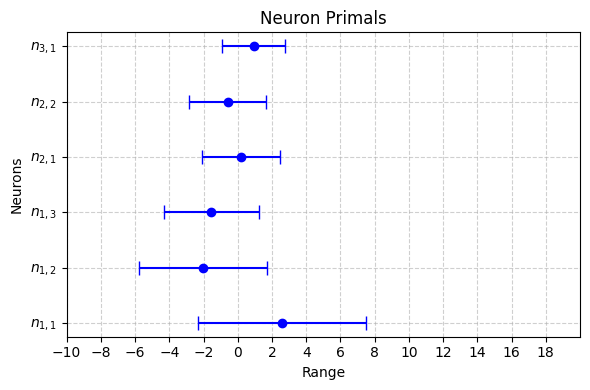

In [197]:
plot_primals()

In [198]:
def plot_adjoints():
    
    adjoints = []
    for layer in modelLike:
        if layer.grad:
            for i in range(len(layer.adjoint.lower)):
                adjoints.append([layer.adjoint.lower[i].item(), layer.adjoint.upper[i].item()])
                
    # Midpoints and half-widths for plotting
    centers = [(x[0] + x[1]) / 2 for x in adjoints]
    errors = [(x[1] - x[0]) / 2 for x in adjoints]
    
    # Plot
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.errorbar(centers, neuron_labels, xerr=errors, fmt='o', capsize=5, linestyle='none', color='blue')
    ax.set_xlim(-2, 2)  # Set x-axis limits
    
    xticks = np.arange(-2, 3, .5)  # Tick every 10 units
    ax.set_xticks(xticks)
    # Add labels and grid
    ax.set_xlabel('Range')
    ax.set_ylabel('Neurons')
    ax.set_title('Neurons Input-Adjoints')
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('neurons_adjoints.png', dpi=300)
    plt.show()

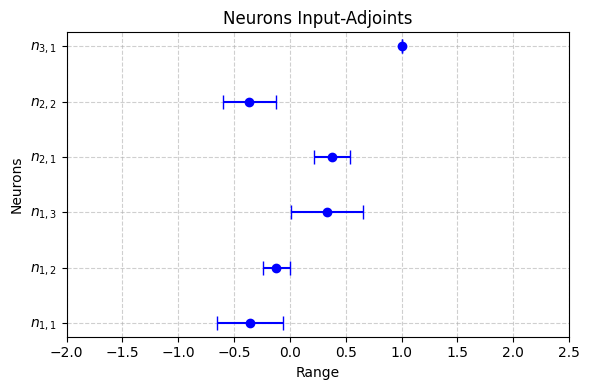

In [199]:
plot_adjoints()

### Remove Neurons One-at-a-time

In [200]:
# each column in weight matrix is a neuron

def remove_n_1_1():
    modelLikecp = copy.deepcopy(modelLike)
    modelLikecp[0].weight = modelLikecp[0].weight[:, 1:]
    modelLikecp[0].bias = modelLikecp[0].bias[1:]
    modelLikecp[2].weight = modelLikecp[2].weight[1:]
    return modelLikecp
    
def remove_n_1_2():
    modelLikecp = copy.deepcopy(modelLike)
    modelLikecp[0].weight = torch.nn.Parameter(torch.cat([modelLikecp[0].weight[:, :1], modelLikecp[0].weight[:, 2:]], axis=1))
    modelLikecp[0].bias = torch.nn.Parameter(torch.cat([modelLikecp[0].bias[:1], modelLikecp[0].bias[2:]]))
    modelLikecp[2].weight = torch.nn.Parameter(torch.cat([modelLikecp[2].weight[:1], modelLikecp[2].weight[2:]]))
    return modelLikecp
    
def remove_n_1_3():
    modelLikecp = copy.deepcopy(modelLike)
    modelLikecp[0].weight = modelLikecp[0].weight[:, :2]
    modelLikecp[0].bias = modelLikecp[0].bias[:2]
    modelLikecp[2].weight = modelLikecp[2].weight[:2]
    return modelLikecp
    
def remove_n_2_1():
    modelLikecp = copy.deepcopy(modelLike)
    modelLikecp[2].weight = modelLikecp[2].weight[:, 1:]
    modelLikecp[2].bias = modelLikecp[2].bias[1:]
    modelLikecp[4].weight = modelLikecp[4].weight[1:]
    return modelLikecp

def remove_n_2_2():
    modelLikecp = copy.deepcopy(modelLike)
    modelLikecp[2].weight = modelLikecp[2].weight[:, :1]
    modelLikecp[2].bias = modelLikecp[2].bias[:1]
    modelLikecp[4].weight = modelLikecp[4].weight[:1]
    return modelLikecp
    

In [240]:
def evaluate(model):
    x = torch.linspace(-1, 1, 1000)
    x = torch.stack((x, x), axis=1)
    y = model(x)
    y_true = f(x).unsqueeze(1)
    criterion = nn.MSELoss()
    loss = criterion(y, y_true)
    return loss.item()

In [250]:
evaluate(model)

0.027908843010663986

In [251]:
def print_weights(layers):
    for layer in layers:
        if layer.grad:
            print(f"{layer.name}")
            print('weight: ', layer.weight)
            print('bias: ', layer.bias)
    print('--' * 20)

In [252]:
prune_losses = []
for i in range(5):
    if i == 0:
        pruned_modelLike = remove_n_1_1()
        pruned_model = nnModuleLike_to_nnModule(pruned_modelLike, model)
        loss = abs(0.0279088 - evaluate(pruned_model))
        print(f"removed neuron n_1_1, loss {loss}")
        print_weights(pruned_modelLike)
        prune_losses.append(loss)
    if i == 1:
        pruned_modelLike = remove_n_1_2()
        pruned_model = nnModuleLike_to_nnModule(pruned_modelLike, model)
        loss = abs(0.0279088 - evaluate(pruned_model))
        print(f"removed neuron n_1_2, loss {loss}")
        print_weights(pruned_modelLike)
        prune_losses.append(loss)
    if i == 2:
        pruned_modelLike = remove_n_1_3()
        pruned_model = nnModuleLike_to_nnModule(pruned_modelLike, model)
        loss = abs(0.0279088 - evaluate(pruned_model))
        print(f"removed neuron n_1_3, loss {loss}")
        print_weights(pruned_modelLike)
        prune_losses.append(loss)
    if i == 3:
        pruned_modelLike = remove_n_2_1()
        pruned_model = nnModuleLike_to_nnModule(pruned_modelLike, model)
        loss = abs(0.0279088 - evaluate(pruned_model))
        print(f"removed neuron n_2_1, loss {loss}")
        print_weights(pruned_modelLike)
        prune_losses.append(loss)
    if i == 4:
        pruned_modelLike = remove_n_2_2()
        pruned_model = nnModuleLike_to_nnModule(pruned_modelLike, model)
        loss = abs(0.02790881 - evaluate(pruned_model))
        print(f"removed neuron n_2_2, loss {loss}")
        print_weights(pruned_modelLike)
        prune_losses.append(loss)

removed neuron n_1_1, loss 2.6975631734191894
fc1
weight:  tensor([[-1.1743, -2.2772],
        [ 2.5568, -0.5027]])
bias:  tensor([-2.0148, -1.5579])
fc2
weight:  tensor([[-0.9540,  0.7510],
        [ 2.5965, -2.0245]])
bias:  tensor([ 0.6572, -1.4918])
fc3
weight:  tensor([[ 2.1636],
        [-2.4127]])
bias:  tensor([0.8917])
----------------------------------------
removed neuron n_1_2, loss 0.00912776792640686
fc1
weight:  Parameter containing:
tensor([[-3.0554, -2.2772],
        [-1.8597, -0.5027]], requires_grad=True)
bias:  Parameter containing:
tensor([ 2.6050, -1.5579], requires_grad=True)
fc2
weight:  Parameter containing:
tensor([[-1.9755,  2.5450],
        [ 2.5965, -2.0245]], requires_grad=True)
bias:  tensor([ 0.6572, -1.4918])
fc3
weight:  tensor([[ 2.1636],
        [-2.4127]])
bias:  tensor([0.8917])
----------------------------------------
removed neuron n_1_3, loss 0.8214470764457703
fc1
weight:  tensor([[-3.0554, -1.1743],
        [-1.8597,  2.5568]])
bias:  tensor([

In [253]:
def plot_prune_loss():
    x_pos = range(len(prune_losses))  
    min_val = min(prune_losses) - 1
    max_val = max(prune_losses) + 1
    y_ticks = np.linspace(np.floor(min_val), np.ceil(max_val), 10)

    plt.figure(figsize=(6, 4))
    plt.scatter(x_pos, prune_losses, color='blue')
    plt.xticks(ticks=x_pos, labels=neuron_labels[:-1])
    plt.yticks(ticks=y_ticks)
    
    
    plt.grid(True)
    plt.xlabel("Neuron")
    plt.ylabel("Impact") 
    plt.title("Influence of Neuron")
    plt.savefig('pruning_loss.png')
    plt.tight_layout()
    plt.show()

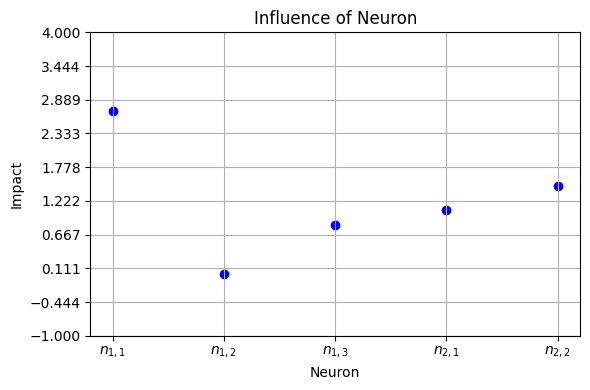

In [254]:
plot_prune_loss()

### Neurons Significance

In [255]:
def calculate_significance():
    
    primals = []
    for layer in modelLike[:-1]:
        if layer.grad:
            for i in range(len(layer.primal.lower)):
                primals.append([layer.primal.lower[i].item(), layer.primal.upper[i].item()])
                
    adjoints = []
    for layer in modelLike[:-1]:
        if layer.grad:
            for i in range(len(layer.adjoint.lower)):
                adjoints.append([layer.adjoint.lower[i].item(), layer.adjoint.upper[i].item()])
    sig = []
    for label, prim, adj in zip(neuron_labels[:-1], primals, adjoints):
        sig.append((prim[1] - prim[0]) * max(abs(adj[0]), abs(adj[1])))
        print(f'Neuron: {label}\n Interval-Primal: {prim}\n Interval-Adjoint: {adj}\n Significance: {sig[-1]}')
    return sig

In [256]:
sig = calculate_significance()

Neuron: $n_{1,1}$
 Interval-Primal: [-2.3101000785827637, 7.520100116729736]
 Interval-Adjoint: [-0.6509070992469788, -0.0610206313431263]
 Significance: 6.398547094147943
Neuron: $n_{1,2}$
 Interval-Primal: [-5.7459001541137695, 1.7162997722625732]
 Interval-Adjoint: [-0.2422507405281067, -0.0009454067330807447]
 Significance: 1.8077234581334523
Neuron: $n_{1,3}$
 Interval-Primal: [-4.337800025939941, 1.2220001220703125]
 Interval-Adjoint: [0.010283689014613628, 0.6563936471939087]
 Significance: 3.649417496821684
Neuron: $n_{2,1}$
 Interval-Primal: [-2.092402935028076, 2.4813694953918457]
 Interval-Adjoint: [0.21154198050498962, 0.5408999919891357]
 Significance: 2.4739534709742657
Neuron: $n_{2,2}$
 Interval-Primal: [-2.8233742713928223, 1.662298321723938]
 Interval-Adjoint: [-0.6031749844551086, -0.12770363688468933]
 Significance: 2.7056454966239087


In [257]:
def plot_significance():
    
    x_pos = range(len(sig))  
    min_val = min(sig) - 1
    max_val = max(sig) + 1
    y_ticks = np.linspace(np.floor(min_val), np.ceil(max_val), 10)

    plt.figure(figsize=(6, 4))
    plt.scatter(x_pos, sig, color='blue')
    plt.xticks(ticks=x_pos, labels=neuron_labels[:-1])
    plt.yticks(ticks=y_ticks)
    
    
    plt.grid(True)
    plt.xlabel("Neurons")
    plt.ylabel("Significance Measure") 
    plt.title("Neurons Significance")
    plt.tight_layout()
    plt.savefig('neurons_significance.png', dpi=300)
    plt.show()

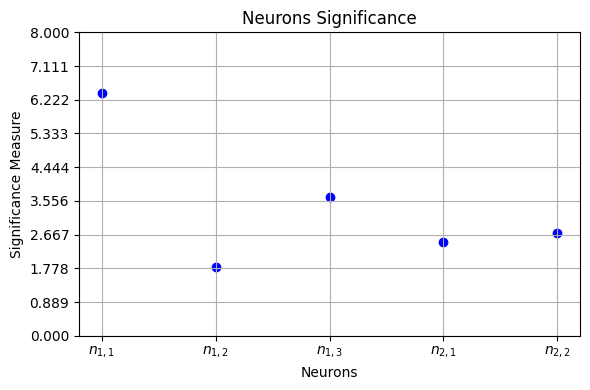

In [258]:
plot_significance()

### Analyze Neuron Significance with Loss

In [259]:
def analyse_neuron_effect():
    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(sig, prune_losses, color='blue')
    
    # Annotate each point
    for i, label in enumerate(neuron_labels[:-1]):
        plt.annotate(label, (sig[i], prune_losses[i]), 
                     textcoords="offset points", xytext=(5, 5), ha='left', fontsize=9)
    
    y_min, y_max = np.ceil(min(prune_losses)-1), np.floor(max(prune_losses) +1)
    plt.yticks(np.linspace(y_min, y_max, 10))  # Increase 20 evenly spaced y-ticks

    # Axis labels
    plt.xlabel("Neuron Significance")
    plt.ylabel("Model Loss")
    plt.title("Pruning Analysis")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('pruning_analysis.png', dpi=300)
    plt.show()

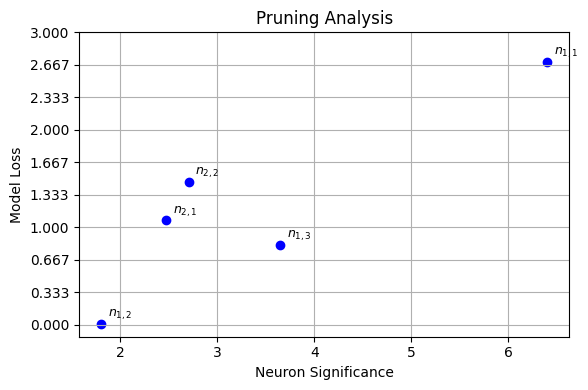

In [260]:
analyse_neuron_effect()

In [261]:
sig, prune_losses

([6.398547094147943,
  1.8077234581334523,
  3.649417496821684,
  2.4739534709742657,
  2.7056454966239087],
 [2.6975631734191894,
  0.00912776792640686,
  0.8214470764457703,
  1.0691107531845092,
  1.4666325966314697])